이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [71]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

**예나 날씨 데이터셋 조사하기**

In [72]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [73]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [74]:
raw_data.shape

(420451, 14)

**전체 기온을 그래프로 그리기**

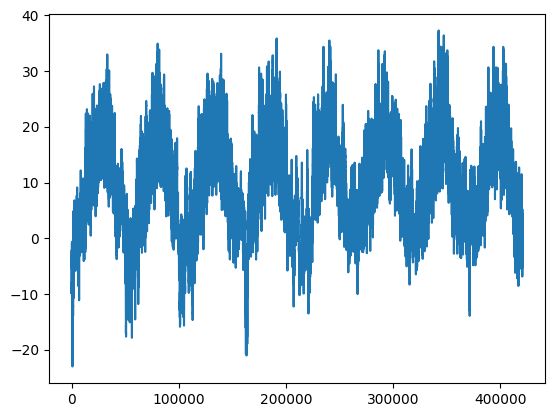

In [75]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

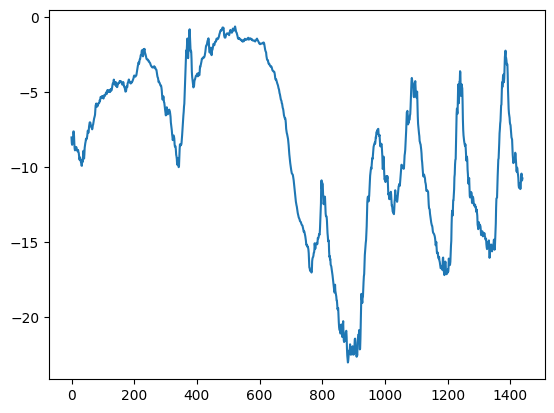

In [76]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [77]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [78]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [79]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2024-06-07 03:31:29.313418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**훈련, 검증, 테스트 데이터셋 만들기**

In [80]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [81]:
# 데이터셋 크기 확인
print(f"train_dataset 크기: {len(train_dataset)}")
print(f"val_dataset 크기: {len(val_dataset)}")
print(f"test_dataset 크기: {len(test_dataset)}")

for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

train_dataset

train_dataset 크기: 819
val_dataset 크기: 408
test_dataset 크기: 405
샘플 크기: (256, 120, 14)
타깃 크기: (256,)


<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [82]:
sequence_length, raw_data.shape[-1]

(120, 14)

### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [83]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

2024-06-07 03:31:32.440305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


검증 MAE: 2.44
테스트 MAE: 2.62


2024-06-07 03:31:35.303445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [84]:
# from tensorflow import keras
# from tensorflow.keras import layers

# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_dense.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

# model = keras.models.load_model("jena_dense.keras")
# print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

**결과 그래프 그리기**

In [86]:
# import matplotlib.pyplot as plt
# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "b", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

### 1D 합성곱 모델 시도해 보기

In [87]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2024-06-07 03:31:36.150781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-07 03:31:36.489634: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 22/819 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 114.4208 - mae: 8.7261

I0000 00:00:1717731098.886542    9554 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 32.8958 - mae: 4.3887 - val_loss: 16.0450 - val_mae: 3.1606
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 16.3936 - mae: 3.2243 - val_loss: 14.5855 - val_mae: 3.0225
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 15.0283 - mae: 3.0844 - val_loss: 15.7513 - val_mae: 3.1175
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 14.0270 - mae: 2.9765 - val_loss: 14.7959 - val_mae: 3.0608
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 13.2519 - mae: 2.8936 - val_loss: 15.0118 - val_mae: 3.0888
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 12.7300 - mae: 2.8331 - val_loss: 14.0519 - val_mae: 2.9510
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 12.3098 - mae: 2.7857 - val_loss: 16.5749 - val_mae: 3.2035
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 11.8893 - mae: 2.7353 - val_loss: 13.9926 - val_mae: 2.9506
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s

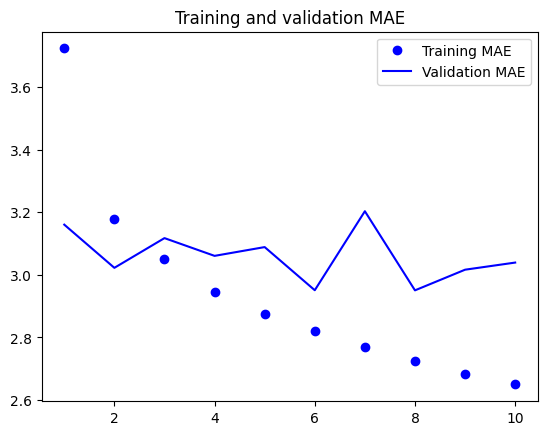

In [88]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [89]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 69.8239 - mae: 6.3963 - val_loss: 12.9068 - val_mae: 2.7416
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 12.1767 - mae: 2.6969 - val_loss: 9.9357 - val_mae: 2.4563
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 10.0845 - mae: 2.4853 - val_loss: 9.5954 - val_mae: 2.4133
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 9.5448 - mae: 2.4167 - val_loss: 9.8694 - val_mae: 2.4442
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 9.1524 - mae: 2.3636 - val_loss: 10.0318 - val_mae: 2.4657
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.8825 - mae: 2.3265 - val_loss: 9.9181 - val_mae: 2.4526
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.6408 - mae: 2.2929 - val_loss: 9.8903 - val_mae: 2.4578
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.4160 - mae: 2.2659 - val_loss: 9.9468 - val_mae: 2.4527
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

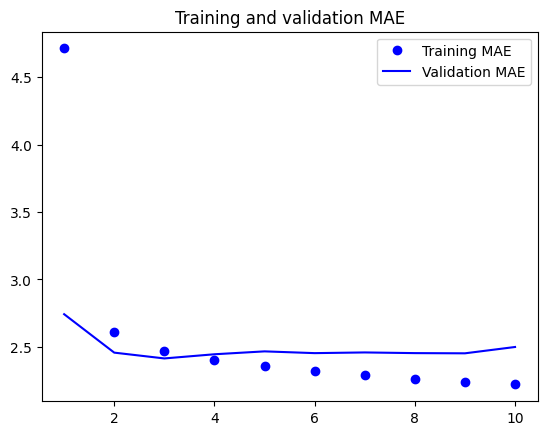

In [90]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [91]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [92]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [93]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [94]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [95]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [96]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 48.1183 - mae: 5.1208 - val_loss: 9.5335 - val_mae: 2.3989
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 14.9485 - mae: 3.0093 - val_loss: 9.6913 - val_mae: 2.4282
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 13.6397 - mae: 2.8683 - val_loss: 10.5633 - val_mae: 2.5429
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 12.9212 - mae: 2.7851 - val_loss: 9.8972 - val_mae: 2.4468
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 12.3786 - mae: 2.7335 - val_loss: 9.8403 - val_mae: 2.4360
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 11.7821 - mae: 2.6633 - val_loss: 9.9215 - val_mae: 2.4599
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 11.3788 - mae: 2.6165 - val_loss: 9.5461 - val_mae: 2.4106
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 11.0900 - mae: 2.5797 - val_loss: 9.6902 - val_mae: 2.4302
Epoch 9/50
819/819 ━━━━━━━━━━━━

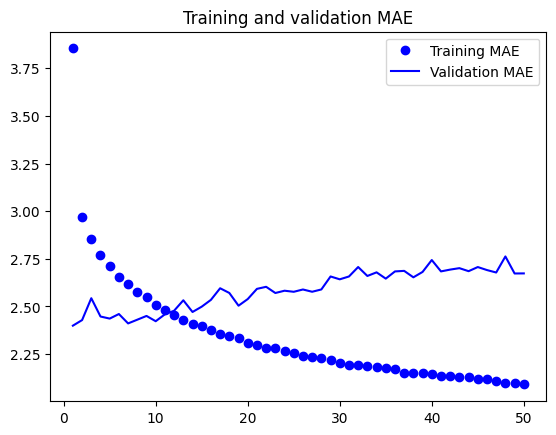

In [97]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [98]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [99]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 44.3490 - mae: 4.9000 - val_loss: 10.1028 - val_mae: 2.4696
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 13.7412 - mae: 2.8699 - val_loss: 9.1352 - val_mae: 2.3469
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 12.8029 - mae: 2.7728 - val_loss: 9.6981 - val_mae: 2.4194
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 12.0960 - mae: 2.6965 - val_loss: 9.1865 - val_mae: 2.3638
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 11.4192 - mae: 2.6219 - val_loss: 10.0017 - val_mae: 2.4746
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 10.7872 - mae: 2.5482 - val_loss: 9.9197 - val_mae: 2.4467
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 10.2804 - mae: 2.4851 - val_loss: 10.6933 - val_mae: 2.5611
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 9.6495 - mae: 2.4117 - val_loss: 10.6701 - val_mae: 2.5546
Epoch 9/50
819/819 ━━━━━━━━━━

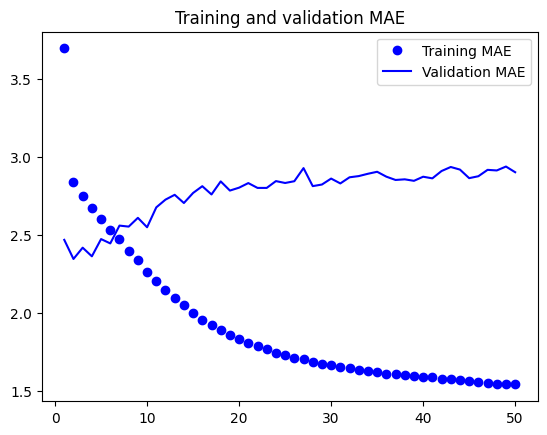

In [100]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [101]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets

train_gen = train_generator()
val_gen = val_generator()

In [102]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 55.5245 - mae: 5.6802

2024-06-07 04:07:01.987195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 55.4998 - mae: 5.6788 - val_loss: 17.4433 - val_mae: 3.3082
Epoch 2/10
  1/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 22.6599 - mae: 3.7561

2024-06-07 04:07:05.911575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


815/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21.6234 - mae: 3.6328

2024-06-07 04:07:18.169805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 21.6201 - mae: 3.6325 - val_loss: 16.4279 - val_mae: 3.1854
Epoch 3/10
  1/819 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 19.7408 - mae: 3.4375

2024-06-07 04:07:21.680410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


818/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19.6418 - mae: 3.4438

2024-06-07 04:07:34.031585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 19.6406 - mae: 3.4437 - val_loss: 16.3948 - val_mae: 3.1475
Epoch 4/10
  1/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 18.3838 - mae: 3.3437

2024-06-07 04:07:37.614108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


816/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 18.1035 - mae: 3.2923

2024-06-07 04:07:49.901411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:07:53.232898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 18.1002 - mae: 3.2920 - val_loss: 14.0406 - val_mae: 2.9066
Epoch 5/10
817/819 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16.0545 - mae: 3.1208

2024-06-07 04:08:06.389868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:08:09.714389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 16.0525 - mae: 3.1206 - val_loss: 12.5055 - val_mae: 2.7356
Epoch 6/10
816/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.3828 - mae: 2.9559

2024-06-07 04:08:22.237476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:08:25.565069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 14.3818 - mae: 2.9558 - val_loss: 11.3662 - val_mae: 2.6108
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13.7262 - mae: 2.8818

2024-06-07 04:08:38.047817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:08:41.378657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 13.7260 - mae: 2.8817 - val_loss: 11.5952 - val_mae: 2.6349
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13.2050 - mae: 2.8304

2024-06-07 04:08:53.810581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:08:57.138487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 13.2048 - mae: 2.8304 - val_loss: 11.8456 - val_mae: 2.6785
Epoch 9/10
815/819 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12.8961 - mae: 2.7946

2024-06-07 04:09:09.664416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:09:12.588130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 12.8954 - mae: 2.7945 - val_loss: 11.3378 - val_mae: 2.6199
Epoch 10/10
815/819 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12.5088 - mae: 2.7456

2024-06-07 04:09:26.115573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-07 04:09:29.161072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 12.5082 - mae: 2.7455 - val_loss: 11.0503 - val_mae: 2.5957


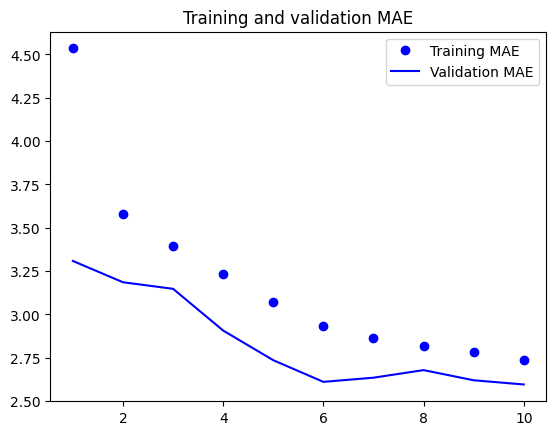

In [103]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [104]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 53.9089 - mae: 5.4190 - val_loss: 11.1308 - val_mae: 2.5881
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 10.1315 - mae: 2.4974 - val_loss: 9.8194 - val_mae: 2.4117
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 8.7936 - mae: 2.3192 - val_loss: 9.5429 - val_mae: 2.3602
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 8.0558 - mae: 2.2144 - val_loss: 9.9623 - val_mae: 2.4030
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 7.5029 - mae: 2.1343 - val_loss: 9.8707 - val_mae: 2.3868
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 7.0953 - mae: 2.0717 - val_loss: 10.3053 - val_mae: 2.4608
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 6.8381 - mae: 2.0317 - val_loss: 11.1278 - val_mae: 2.5346
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 6.5929 - mae: 1.9967 - val_loss: 10.4649 - val_mae: 2.4794
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

### 더 나아가서

## 요약